In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [3]:
import examples.ice_melting.configs as cfg
from examples.ice_melting.model import PINN


cfg = cfg.Config()
pinn = PINN(config=cfg)
fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = [float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames]
ts = jnp.array(ts)
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]

In [ ]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/ice-melting/irr/baseline-4/model-4000/")
# state_noirr = ckpt.restore("/root/tf-logs/ice-melting/noirr/baseline-causal/model-2500/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/ice-melting/noirr/baseline-3/model-4000/")
params = state["params"]
params_noirr = state_noirr["params"]

: 

In [5]:
pred_radius = []
pred_radius_noirr = []
fem_radius = []
analytic_radius = []
skip_every = 1


def compute_radius(sol: jnp.ndarray):
    # interface_mask = (sol > -0.1) & (sol < 0.1)
    # selected_mesh = mesh[interface_mask]
    # return jnp.mean(jnp.linalg.norm(selected_mesh, axis=1)) * cfg.Lc
    volume_fraction = jnp.mean(jnp.where(sol > 0, 1, 0))
    # use the volume fraction to compute the radius
    r = (3 * volume_fraction / (4 * jnp.pi)) ** (1 / 3)
    return r * cfg.Lc

ts = jnp.arange(0, 5.1, 0.1)
mesh = jnp.load(f"{cfg.DATA_PATH}mesh_points.npy")[::skip_every] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()
    pred_noirr = vmap(pinn.net_u, in_axes=(None, 0, 0))(params_noirr, mesh, t).squeeze()
    # Rt = cfg.R0 - cfg.LAMBDA * tic
    # Rxyz = jnp.sqrt(mesh[:, 0] ** 2 + mesh[:, 1] ** 2 + mesh[:, 2] ** 2) * cfg.Lc
    # ref_sol = jnp.tanh((Rt - Rxyz) / (jnp.sqrt(2) * cfg.EPSILON))
    
    ref_sol = jnp.load(f"{cfg.DATA_PATH}sol-{tic:.4f}.npy")[::skip_every]
    
    
    diff = jnp.abs(pred - ref_sol)
    pred_radius.append(compute_radius(pred))
    pred_radius_noirr.append(compute_radius(pred_noirr))
    fem_radius.append(compute_radius(ref_sol))
    analytic_radius.append(cfg.R0 - cfg.LAMBDA * tic)

In [6]:
%matplotlib inline

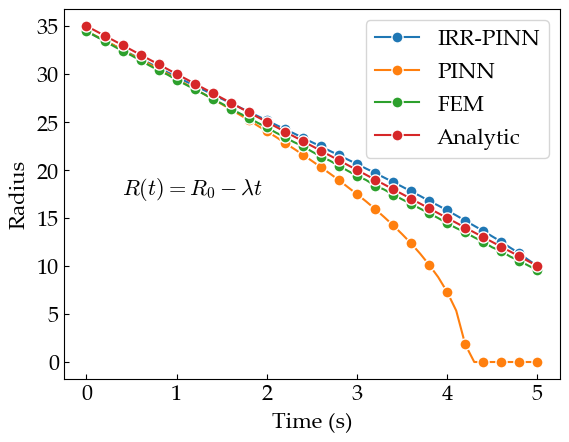

In [7]:

fig, ax = plt.subplots()
ax.plot(ts, pred_radius, label="IRR-PINN", marker="o", markevery=2, markeredgecolor="white", markersize=8)
ax.plot(ts, pred_radius_noirr, label="PINN", marker="o", markevery=2, markeredgecolor="white", markersize=8)
ax.plot(ts, fem_radius, label="FEM", marker="o", markevery=2, markeredgecolor="white", markersize=8)
ax.plot(ts, analytic_radius, label="Analytic", marker="o", markevery=2, markeredgecolor="white", markersize=8)

# put the formulation of the analytic solution
ax.text(0.4, 0.5, r"$R(t) = R_0 - \lambda t$", transform=ax.transAxes, ha="right")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Radius")

ax.legend()

plt.savefig("figures/icemelting-radius.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/icemelting-radius.pdf", dpi=300, bbox_inches="tight")

In [8]:


def evaluate3D(pinn, params, mesh, ref_path, ts, **kwargs):
    fig = plt.figure(figsize=(3 * len(ts), 8))
    gs = GridSpec(4, len(ts) + 1, width_ratios=[0.1] + [1] * len(ts), height_ratios=[1, 1, 1, 0.3],
                  figure=fig)

    xlim = kwargs.get("xlim", (-0.5, 0.5))
    ylim = kwargs.get("ylim", (-0.5, 0.5))
    zlim = kwargs.get("zlim", (-0.5, 0.5))
    Lc = kwargs.get("Lc", 100)
    Tc = kwargs.get("Tc", 1.0)

    error = 0
    mesh /= Lc
    # mesh = mesh[::10]
    
    row_names = ["PINN", "FEM", "Error"]
    for idx, row_name in enumerate(row_names):
        ax = fig.add_subplot(gs[idx, 0])
        # put row name on the left vertical axis
        ax.text(0.5, 0.5, row_name, transform=ax.transAxes, 
                rotation=90, ha="center", va="center")
        ax.set_axis_off()

    for idx, tic in enumerate(ts):
        t = jnp.ones_like(mesh[:, 0:1]) * tic / Tc
        pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()

        ax = fig.add_subplot(gs[0, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = (pred > -0.5) & (pred < 0.5)
        ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=pred[interface_idx],
            cmap="coolwarm",
            label="phi",
            vmin=-1,
            vmax=1,
        )
        # r_pinn = (
        #     jnp.sqrt(
        #         mesh[interface_idx, 0] ** 2
        #         + mesh[interface_idx, 1] ** 2
        #         + mesh[interface_idx, 2] ** 2
        #     )
        #     * Lc
        # )
        r_pinn = compute_radius(pred)

        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            title=f"t={tic}",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        ax.set_axis_off()
        ax.invert_zaxis()

        Rt = cfg.R0 - cfg.LAMBDA * tic
        Rxyz = jnp.sqrt(mesh[:, 0] ** 2 + mesh[:, 1] ** 2 + mesh[:, 2] ** 2) * Lc
        ref_sol = jnp.tanh((Rt - Rxyz) / (jnp.sqrt(2) * cfg.EPSILON))
        diff = jnp.abs(pred - ref_sol)

        ax = fig.add_subplot(gs[1, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = (ref_sol > -0.5) & (ref_sol < 0.5)
        ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=ref_sol[interface_idx],
            cmap="coolwarm",
            label="phi",
            vmin=-1,
            vmax=1,
        )
        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        ax.set_axis_off()

        ax = fig.add_subplot(gs[2, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = diff > 0.05
        error_bar = ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=jnp.abs(pred[interface_idx] - ref_sol[interface_idx]),
            cmap="coolwarm",
            label="error",
        )

        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        error += jnp.mean(diff**2)

        ax.set_axis_off()
        ax.invert_zaxis()

        interface_idx = jnp.where((ref_sol > -0.5) & (ref_sol < 0.5))[0]
        r_fem = compute_radius(ref_sol)
        # r_fem = (
        #     jnp.sqrt(
        #         mesh[interface_idx, 0] ** 2
        #         + mesh[interface_idx, 1] ** 2
        #         + mesh[interface_idx, 2] ** 2
        #     )
        #     * Lc
        # )
        r_analytical = cfg.R0 - cfg.LAMBDA * tic

        ax.text2D(
            0.05,
            -0.2,
            f"R_analytical = {r_analytical:.2f}\n"
            f"R_pinn = {jnp.mean(r_pinn):.2f}\n"
            f"R_fem = {jnp.mean(r_fem):.2f}",
            transform=ax.transAxes,
            ha="left",
            va="bottom",
        )
        
        ax = fig.add_subplot(gs[3, idx + 1])
        fig.colorbar(error_bar, ax=ax, orientation='horizontal')
        ax.set_axis_off()

    error /= len(ts)
    return fig, error

Text(0.5, 0.98, 'With Irreversible Constraint')

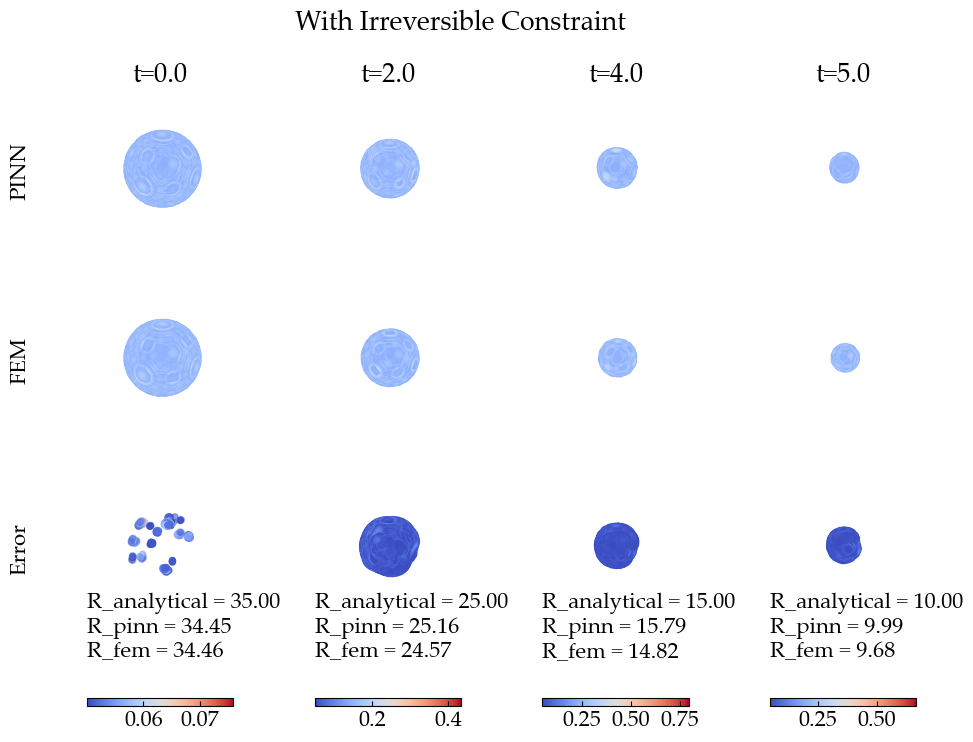

In [9]:
fig, error = evaluate3D(
            pinn,
            params,
            jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy"),
            cfg.DATA_PATH,
            ts=cfg.TS,
            Lc=cfg.Lc,
            Tc=cfg.Tc,
            xlim=cfg.DOMAIN[0],
            ylim=cfg.DOMAIN[1],
            zlim=cfg.DOMAIN[2],
        )
fig.suptitle(f"With Irreversible Constraint")

Text(0.5, 0.98, 'Without Irreversible Constraint')

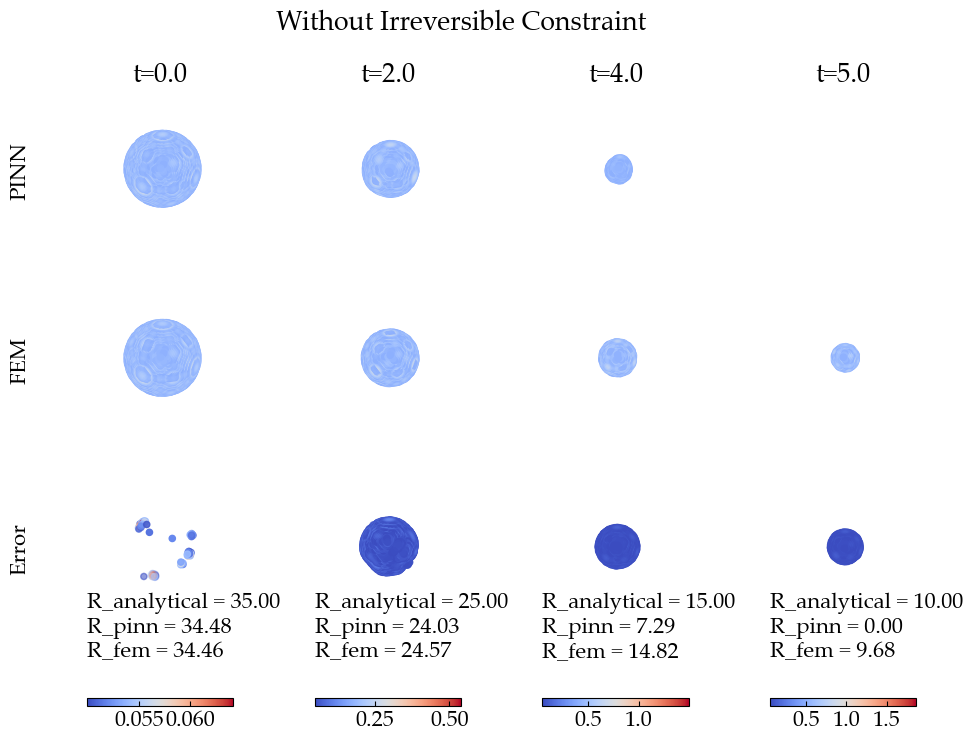

In [10]:
fig, error = evaluate3D(
            pinn,
            params_noirr,
            jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy"),
            cfg.DATA_PATH,
            ts=cfg.TS,
            Lc=cfg.Lc,
            Tc=cfg.Tc,
            xlim=cfg.DOMAIN[0],
            ylim=cfg.DOMAIN[1],
            zlim=cfg.DOMAIN[2],
        )
fig.suptitle(f"Without Irreversible Constraint")

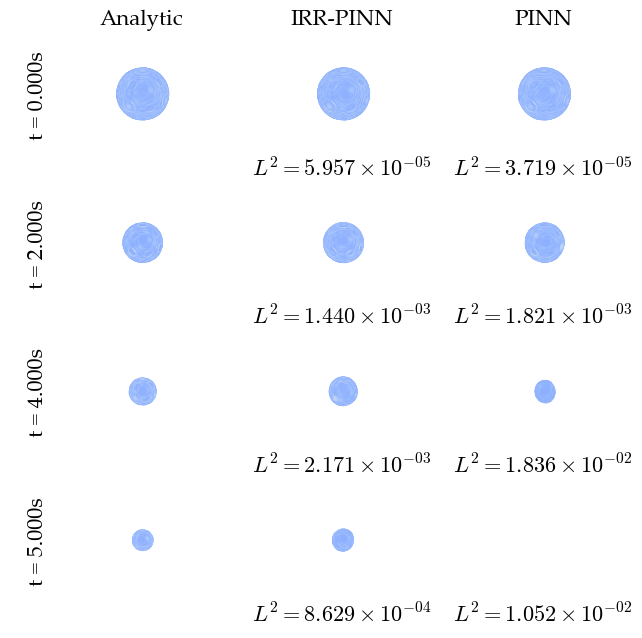

In [11]:
ts = cfg.TS
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(1+len(ts)*2, 4, height_ratios=[0.2] + [1, 0.2,]*len(ts), width_ratios=[0.1] + [1]*3)

col_names = ["", "Analytic", "IRR-PINN", "PINN"]
for i, col_name in enumerate(col_names):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.0, col_name, ha="center", va="bottom",
            transform=ax.transAxes, rotation=0)
    ax.axis("off")
    
    
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for i, tic in enumerate(ts):
    
    ax = fig.add_subplot(gs[1+2*i, 0])
    ax.text(1.0, 0.5, f"t = {tic:.3f}s", ha="left", va="center",
            transform=ax.transAxes, rotation=90)
    ax.axis("off")
    
    
    
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params, mesh, t)
    pred_noirr = vmap(
        lambda params, mesh, t: pinn.net_u(params, mesh, t)[0],
        in_axes=(None, 0, 0),
    )(params_noirr, mesh, t)
    Rt = cfg.R0 - cfg.LAMBDA * tic
    Rxyz = jnp.sqrt(mesh[:, 0] ** 2 + mesh[:, 1] ** 2 + mesh[:, 2] ** 2) * cfg.Lc
    ref_sol = jnp.tanh((Rt - Rxyz) / (jnp.sqrt(2) * cfg.EPSILON))
    # ref_sol = jnp.load(f"{cfg.DATA_PATH}sol-{tic:.4f}.npy")[::skip_every]
    
    
    
    def plot_sol(ax, mesh, sol):
        idx = jnp.where((sol > -0.5) & (sol < 0.5))[0]
        ax.scatter(
            mesh[idx, 0],
            mesh[idx, 1],
            mesh[idx, 2],
            c=sol[idx],
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
        )
        ax.set_axis_off()
        ax.set(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5), zlim=(-0.5, 0.5))
        # ax.set_frame_on(False)
        
    def plot_error(ax, ref, sol):
        error = jnp.mean((ref - sol) ** 2)
        error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
        ax.text(0.5, 0.5, error_str, ha="center", va="center",
                transform=ax.transAxes, rotation=0)
        ax.axis("off")
        

    ax = fig.add_subplot(gs[1+2*i, 1], projection="3d", box_aspect=(1, 1, 1))
    plot_sol(ax, mesh, ref_sol)
    ax = fig.add_subplot(gs[1+2*i, 2], projection="3d", box_aspect=(1, 1, 1))
    plot_sol(ax, mesh, pred)
    ax = fig.add_subplot(gs[1+2*i, 3], projection="3d", box_aspect=(1, 1, 1))
    plot_sol(ax, mesh, pred_noirr)
    
    ax = fig.add_subplot(gs[2+2*i, 2])
    plot_error(ax, ref_sol, pred)
    
    ax = fig.add_subplot(gs[2+2*i, 3])
    plot_error(ax, ref_sol, pred_noirr)
    
plt.savefig("figures/icemelting-sol.png", dpi=300, bbox_inches="tight")

In [12]:
epochs = jnp.arange(0, 4000, 25)
error_log = []
error_log_noirr = []
ts = [0.000, 2.0000, 4.000, 5.000]

@jit
def pred_fn(params, x_inp, t_inp):
    return vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params, x_inp, t_inp).squeeze()

for epoch in epochs:
    l2_norms = []
    l2_norms_noirr = []
    state = ckpt.restore(f"/root/autodl-tmp/tf-logs/ice-melting/irr/baseline-4/model-{epoch}/")
    state_noirr = ckpt.restore(f"/root/autodl-tmp/tf-logs/ice-melting/noirr/baseline-3/model-{epoch}/")
    params = state["params"]
    params_noirr = state_noirr["params"]
    for tic in ts:
        t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
        ref_sol = jnp.load(f"{cfg.DATA_PATH}/sol-{tic:.4f}.npy")
        pred = pred_fn(params, mesh, t)
        pred_noirr = pred_fn(params_noirr, mesh, t)
        # l2_norm = jnp.linalg.norm(ref_sol - pred) / jnp.linalg.norm(ref_sol)
        # l2_norm_noirr = jnp.linalg.norm(ref_sol - pred_noirr) / jnp.linalg.norm(ref_sol)
        l2_norm = jnp.mean((ref_sol - pred)**2) / jnp.mean(ref_sol**2)
        l2_norm_noirr = jnp.mean((ref_sol - pred_noirr)**2) / jnp.mean(ref_sol**2)
        l2_norms.append(l2_norm)
        l2_norms_noirr.append(l2_norm_noirr)
    error_log.append(jnp.mean(jnp.array(l2_norms)))
    error_log_noirr.append(jnp.mean(jnp.array(l2_norms_noirr)))

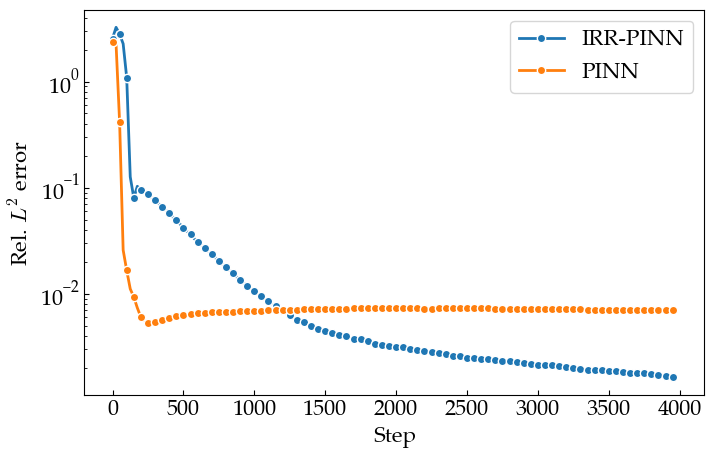

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, error_log, label="IRR-PINN", lw=2, markevery=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(epochs, error_log_noirr, label="PINN", lw=2,markevery=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Rel. $L^2$ error", xlabel="Step", yscale="log",)
ax.legend(loc="upper right",)
plt.savefig("figures/icemelting-relerror-log.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/icemelting-relerror-log.pdf", dpi=300, bbox_inches="tight")

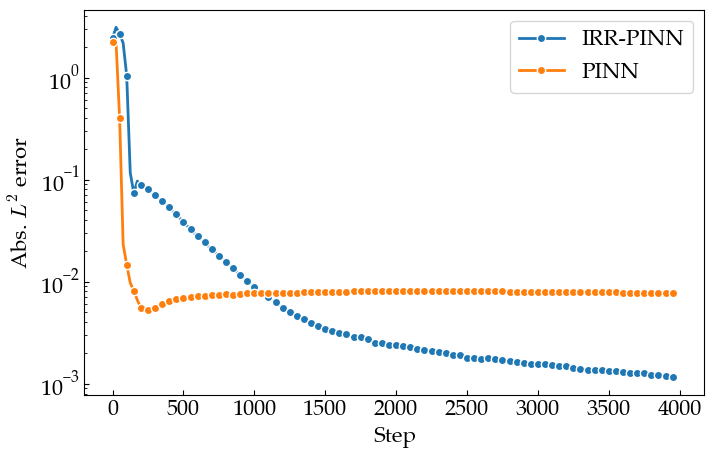

In [5]:
import pandas as pd

%matplotlib inline
error_log = pd.read_csv("./logs-eval/run-ice-melting_irr_baseline-4-tag-error_error.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-ice-melting_noirr_baseline-3-tag-error_error.csv")

error_log = error_log[error_log["Step"] < 4000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 4000]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2, markevery=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Abs. $L^2$ error", xlabel="Step", yscale="log")
ax.legend()
plt.savefig("figures/icemelting-abserror-log.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/icemelting-abserror-log.pdf", dpi=300, bbox_inches="tight")

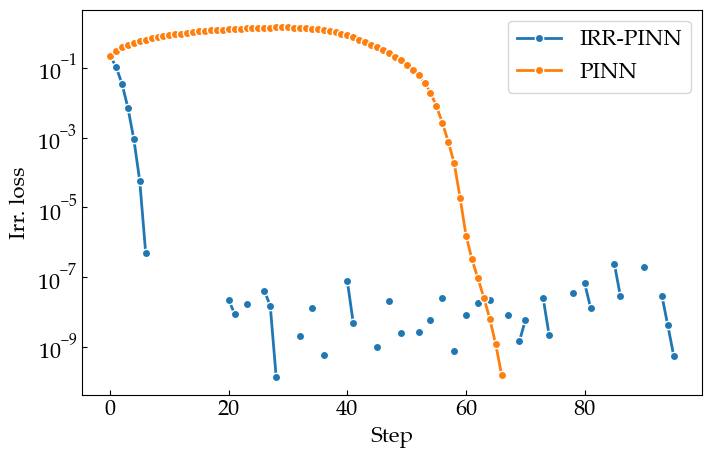

In [8]:
import pandas as pd
# loss_log = pd.read_csv("./logs-eval/run-ice-melting_irr_baseline-4-tag-loss_irr.csv")
# loss_log_noirr = pd.read_csv("./logs-eval/run-ice-melting_noirr_baseline-3-tag-loss_irr.csv")

loss_log = pd.read_csv("./logs-eval/run-ice-melting_irr_2025-09-26-12-17-05-tag-loss_irr.csv")
loss_log_noirr = pd.read_csv("./logs-eval/run-ice-melting_noirr_2025-09-26-12-25-17-tag-loss_irr.csv")


loss_log["Value"] = loss_log["Value"].apply(lambda x : jnp.nan if jnp.abs(x) < 1e-10 else x)
loss_log = loss_log[loss_log["Step"] < 100]
loss_log_noirr["Value"] = loss_log_noirr["Value"].apply(lambda x : jnp.nan if jnp.abs(x) < 1e-10 else x)
loss_log_noirr = loss_log_noirr[loss_log_noirr["Step"] < 100]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_log["Step"], loss_log["Value"], label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(loss_log_noirr["Step"], loss_log_noirr["Value"], label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
plt.savefig("figures/icemelting-irrloss-log.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/icemelting-irrloss-log.pdf", dpi=300, bbox_inches="tight")